# Intent Extraction - creating and training a model

Let's start by importing all the important classes

In [ ]:
import numpy as np
from keras import Input, Model
from keras.layers import Embedding, Dropout, TimeDistributed, Bidirectional, \
    LSTM, concatenate, Dense
from keras_contrib.layers import CRF
from nlp_architect.data.intent_datasets import SNIPS
from nlp_architect.utils.embedding import load_word_embeddings
from nlp_architect.utils.metrics import get_conll_scores

---
## Preparing the data
The first step is the download the dataset into a folder and load the data into the memory
using the `SNIPS` data loader.

### SNIPS NLU Benchmark

7 NLU intents:
- ‘Add to playlist’
- ‘Rate book’
- ‘Check weather’
- ‘Play music’
- ‘Book restaurant’
- ‘Search event’
- ‘Search art’

73 types of labels, train/test set sizes: ~14000/700

More info: [here](https://github.com/snipsco/nlu-benchmark)

We set the maximum sentence and word length.

In [ ]:
sentence_length = 50
word_length = 12

In [ ]:
dataset_path = '<SNIPS folder>/2017-06-custom-intent-engines'
dataset = SNIPS(path=dataset_path,
                sentence_length=sentence_length,
                word_length=word_length)

Once the dataset is loaded, we can extract the ready made `train` and `test` sets. Each set is made up of a tuple of 4 elements:
- Words (`train_x` and `test_x`)
- Word character representation (`train_c` and `test_c`)
- Intent type (`train_i` and `test_i`)
- Token slot tags (`train_y` and `test_y`)

In [ ]:
train_x, train_c, train_i, train_y = dataset.train_set
test_x, test_c, test_i, test_y = dataset.test_set

In [ ]:
train_x.shape, train_c.shape, train_i.shape, train_y.shape

Sentences are encoded in sparse int representation (str->int vocabularies stored in the dataset object) as NumPy arrary.
Lets look at the sentence in index 5544, translate it back to strings so we could read the sentence, and look at the encoded label tags.

In [ ]:
train_x[5544]

In [ ]:
rev_vocab = {v:k for k, v in dataset.tokens_vocab.items()}
words = []
for i in train_x[5544]:
    if i > 0:
        words.append(rev_vocab.get(i))
', '.join(words)

In [ ]:
print(train_y[5544].shape)
print(train_y[5544].argmax(1))
rev_vocab = {v:k for k, v in dataset.labels_vocab.items()}
labels = []
for i in train_y[5544].argmax(1):
    if i > 0:
        labels.append(rev_vocab.get(i))
', '.join(labels)

---
### External word embedding

Now it's time to load the external word embedding model.
We'll use `load_word_embeddings` function that reads the file and loads up the words into numpy arrays.
Once done, we'll create a 2D array with the words we have in our dataset word lexicon - we'll save it in `embedding_matrix` and we'll use it later when we load the embedding layer of the words.
You can download the word embedding models from [here](https://nlp.stanford.edu/projects/glove/).

In [ ]:
embedding_path = 'glove.6B.100d.txt'
embedding_size = 100

external_emb, emb_size = load_word_embeddings(embedding_path)
embedding_matrix = np.zeros((dataset.vocab_size, emb_size))
for word, i in dataset.tokens_vocab.items():
    embedding_vector = external_emb.get(word.lower())
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

---
## Building the network

Now for the fun part, let's start by defining the parameters of the network we're going to build, such as, the LSTM layer's hidden state, the number of output labels and intents to predict and the size of the character embedding vectors.

### High level topology

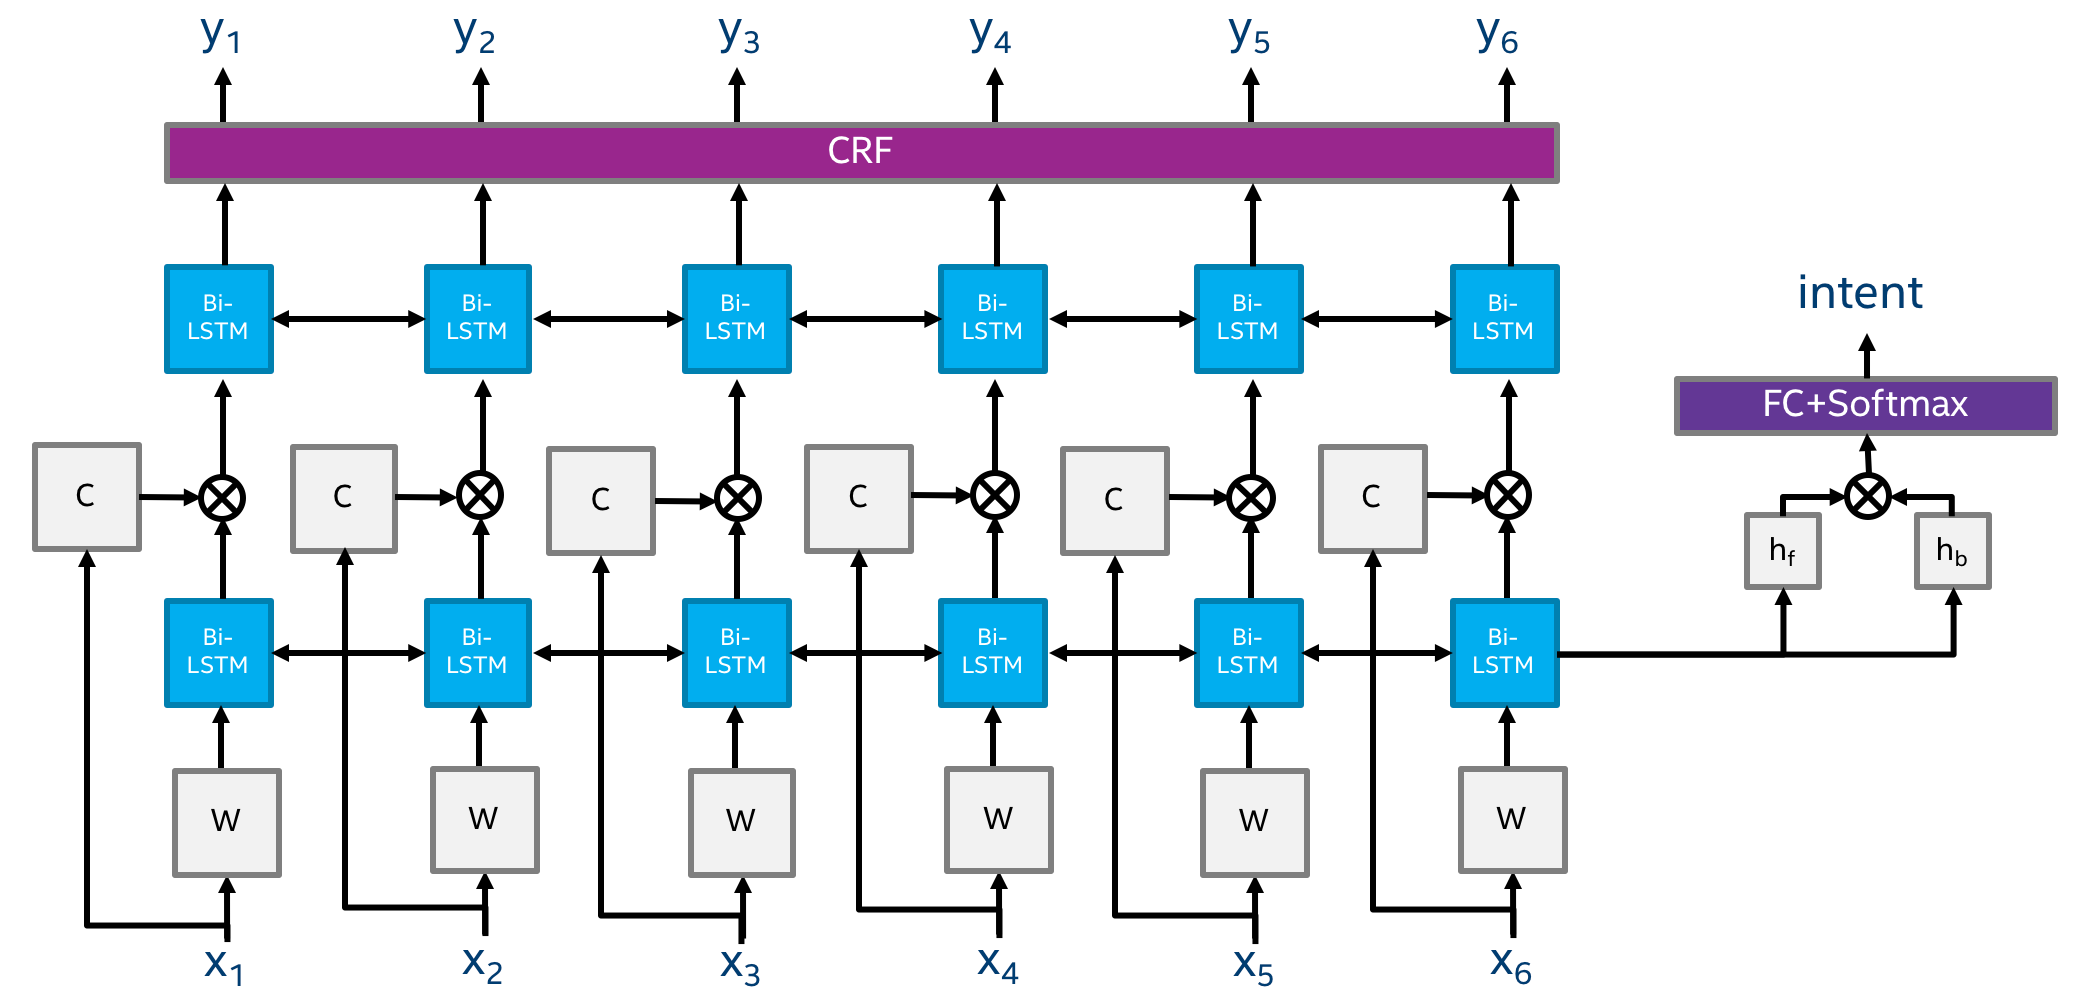

In [ ]:
word_vocabulary_size = dataset.vocab_size
character_vocab_size = dataset.char_vocab_size
character_emb_size = 25
char_lstm_hidden_dims = 25
intent_labels = dataset.intent_size
tagging_lstm_hidden_dims = 100
tag_labels = dataset.label_vocab_size

Our first 2 layers are input layers - our model consumes sentences in 2 forms: words and words made of characters.
We define an `Input` to represent the words input layer, which feeds an embedding layer that is loaded with the previous external word embedding matrix we made (remember `embedding_matrix` ?). If you don't have the external embedding model you can create an embedding layer that will be trained from scratch.

In [ ]:
words_input = Input(shape=(sentence_length,), name='words_input')
embedding_layer = Embedding(word_vocabulary_size, embedding_size, weights=[embedding_matrix],
                            input_length=sentence_length, trainable=True,
                            name='word_embedding_layer')

Run the cell below if you didn't load the external Glove embedding model.

In [ ]:
words_input = Input(shape=(sentence_length,), name='words_input')
embedding_layer = Embedding(word_vocabulary_size, 100,
                            input_length=sentence_length,
                            name='word_embedding_layer')

Once we have an embedding layer we add a dropout and define the input to be its source.

In [ ]:
word_embeddings = embedding_layer(words_input)
word_embeddings = Dropout(0.5)(word_embeddings)

Similarly to what we've already done, we create the 2nd input source for word characters.
This time we will let the network learn the character embedding vectors (instead of pre-loading a train model).

Since we want to use the same character embedding layer for all words in the sentence, and also the same LSTM (that encodes the context of the words) we need to use the `TimeDistributed` layer that applies the same network element to each time-step (2nd index)

In [ ]:
# create word character input and embeddings layer
word_chars_input = Input(shape=(sentence_length, word_length), name='word_chars_input')
char_embedding_layer = Embedding(character_vocab_size, character_emb_size,
                                 input_length=word_length, name='char_embedding_layer')
# apply embedding to each word
char_embeddings = TimeDistributed(char_embedding_layer)(word_chars_input)
# feed dense char vectors into Bi-LSTM
char_embeddings = TimeDistributed(Bidirectional(LSTM(char_lstm_hidden_dims)))(char_embeddings)
char_embeddings = Dropout(0.5)(char_embeddings)

Next step is to create the first bi-directional LSTM layers. We need to add `return_sequences=True, return_state=True` so the LSTM layer will return the `y` output of each time-step and the last hidden states of the layers.

We will feed the `y` states of the LSTM layers to the next LSTM layer later, and using the hidden states we concatenate the `h` vectors and feed into the first classification layer.

The classification is a linear layer with `softmax` that outputs a vector sized as the possible intent types.

In [ ]:
# first (and shared) BiLSTM layer (used for intent classification)
shared_bilstm_layer = Bidirectional(LSTM(100, return_sequences=True, return_state=True))
shared_lstm_out = shared_bilstm_layer(word_embeddings)

shared_lstm_y = shared_lstm_out[:1][0]  # save y states of the LSTM layer
states = shared_lstm_out[1:]
hf, cf, hb, cb = states                   # extract last hidden states
h_state = concatenate([hf, hb], axis=-1)  # concatenate last states
intent_out = Dense(intent_labels, activation='softmax',
                   name='intent_classifier_output')(h_state)

Moving on to the 2nd LSTM layer (the one that will classify the token slot labels).

We concatenate the output of the first layer and the word character embeddings, then feed into a bi-directional LSTM layer. Finally, a CRF is used for classifing the right slot label in each of the time-steps. The output of the network is a tensor of (#number of sentences, #sentence length, #slot labels).

In [ ]:
# concatenate character embeddings with shared LSTM y states
combined_features = concatenate([shared_lstm_y, char_embeddings], axis=-1)

# slot tagging Bi-LSTM layer
tagging_lstm = Bidirectional(LSTM(tagging_lstm_hidden_dims, return_sequences=True))(combined_features)
second_bilstm_layer = Dropout(0.5)(tagging_lstm)

# feed BiLSTM vectors into CRF
crf = CRF(tag_labels, sparse_target=False)
labels_out = crf(second_bilstm_layer)

---
Our model is almost ready!

We create a Keras model and define the input and output channels.

Finally, we compile the model with a loss function, a metric function and an optimizer.

In [ ]:
# compile the model
model = Model(inputs=[words_input, word_chars_input],
              outputs=[intent_out, labels_out])

# define losses and metrics
loss_f = {'intent_classifier_output': 'categorical_crossentropy',
          'crf_1': crf.loss_function}
metrics = {'intent_classifier_output': 'categorical_accuracy',
           'crf_1': crf.accuracy}

model.compile(loss=loss_f,
              optimizer='adam',
              metrics=metrics)

## Training the network
We've got a model, it's time to train the network.

We define the batch size and the number of epochs to run.

In [ ]:
batch_size = 64
no_epochs = 1

# train the model
model.fit([train_x, train_c], [train_i, train_y],
          batch_size=batch_size,
          epochs=no_epochs,
          validation_data=([test_x, test_c], [test_i, test_y]))

## Testing and evaluating the network
Great! we have a trained model, let's check how well it performs.

First, we need to run all the test data through the network and get the network's preditions. Once done, we can use `get_conll_scores` to get the actual CONLLEVAL benchmark results on the test data (in terms of precision/recall/F1 and per label type).

In [ ]:
predictions = model.predict([test_x, test_c], batch_size=batch_size)

In [ ]:
predictions[0].shape, predictions[1].shape

In [ ]:
eval = get_conll_scores(predictions, test_y,
                        {v: k for k, v in dataset.labels_vocab.items()})

In [ ]:
print('Precision {}'.format(eval[0][0]))
print('Recall {}'.format(eval[0][1]))
print('F1 {}'.format(eval[0][2]))

In [ ]:
eval[1]

In [ ]:
from sklearn.metrics import accuracy_score
predicted_intents = predictions[0].argmax(1)
truth_intents = test_i.argmax(1)
accuracy_score(truth_intents, predicted_intents)

Using GloVe 300 word embedding model and 50+ epochs of training should produce a model with:

- Intent detection: >99 F1
- Slot label classification: >95 F1
---

### Saving model weights

In [ ]:
from keras_contrib.utils import save_load_utils
# save model weights
save_load_utils.save_all_weights(model, 'my_model')